In [1]:
import pickle
import requests
import pandas_profiling
import multiprocessing
import json

import numpy   as np
import pandas  as pd
import seaborn as sns

from IPython.core.display    import HTML
from IPython.display         import Image
from tabulate                import tabulate
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, classification_report,confusion_matrix
        
from scipy                   import stats  as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from pandas_profiling        import ProfileReport

import matplotlib.pyplot   as plt
import plotly.express      as px

# 0.0 Imports

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def cramer_v (x,y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = r - (r -1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loanding Data

In [4]:
df_credit = pd.read_csv("credit_risk_dataset.csv", index_col = False, low_memory = False)

In [5]:
df_credit.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
12417,23,80796,MORTGAGE,7.0,MEDICAL,A,5000,NaN,0,0.06,N,3
4047,24,67200,RENT,5.0,HOMEIMPROVEMENT,D,4000,NaN,0,0.06,Y,2
147,23,13200,MORTGAGE,2.0,EDUCATION,B,1400,9.25,0,0.11,N,4
9807,24,64656,MORTGAGE,8.0,EDUCATION,B,14500,10.99,0,0.22,N,4
4133,22,14400,RENT,0.0,HOMEIMPROVEMENT,E,4400,19.91,1,0.31,N,4


# 1.0 Data Descriptive

In [6]:
df1 = df_credit.copy()

# 1.1 Data Dimensions

In [7]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Cols: {}'.format (df1.shape[1]))

Number of Rows: 32581
Number of Cols: 12


# 1.2 Data Types

In [8]:
print(df1.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


# 1.3 Check NA

In [9]:
df1.duplicated().sum()

165

In [10]:
df1 = df1.drop_duplicates()

In [11]:
df1.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

# 1.4 Fillout NA

In [12]:
df_media_int = df1[['loan_int_rate', 'loan_grade']].groupby ('loan_grade').agg('mean').reset_index()

In [13]:
df_media_int

,loan_grade,loan_int_rate
0,A,7.328423
1,B,10.995756
2,C,13.464579
3,D,15.360698
4,E,17.008409
5,F,18.609159
6,G,20.251525


In [14]:
## person_emp_length
# Hipótese para Valor Ausente: Pessoa Desempregada Atualmente

df1['person_emp_length'].fillna(0, inplace = True)

## loan_int_rate
# Hipótese para Valor Ausente: Coleta de Dados Incompleta

grande_int_mean = {'A': 7.328423, 'B': 10.995756, 'C': 13.464579, 'D': 15.360698 , 'E': 17.008409, 'F': 18.609159, 'G': 20.251525}

df1['loan_int_rate'] = df1['loan_int_rate'].fillna(df1['loan_grade'].map(grande_int_mean))

In [86]:
df1.head()

,index,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [87]:
df_dashboard = df1.to_csv('df_dashboard.csv', index = False)

# 1.5 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64'])

# 1.5.1 Numerical Attributes

In [17]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply (np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame (num_attributes.apply (np.std)).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis())).T

# Concatenate

t = pd.concat ((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()
t.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

t

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,person_age,20.00,144.00,124.00,27.747008,26.000000,6.354002,2.580490,18.560231
1,person_income,4000.00,6000000.00,5996000.00,66091.640826,55000.000000,62014.623703,32.958748,2701.116241
2,person_emp_length,0.00,123.00,123.00,4.659427,4.000000,4.162342,2.570074,42.164896
3,loan_amnt,500.00,35000.00,34500.00,9593.845632,8000.000000,6322.632715,1.191944,1.421251
4,loan_int_rate,5.42,23.22,17.80,11.016156,10.995756,3.220359,0.209194,-0.681186
5,loan_status,0.00,1.00,1.00,0.218688,0.000000,0.413357,1.361172,-0.147220
6,loan_percent_income,0.00,0.83,0.83,0.170250,0.150000,0.106810,1.063811,1.217690
7,cb_person_cred_hist_length,2.00,30.00,28.00,5.811297,4.000000,4.058968,1.659369,3.705835


In [18]:
df1 = df1.drop(df1[df1['person_age'] > 100].index)
df1 = df1.drop(df1[df1['person_emp_length'] > 50].index).reset_index()

In [19]:
df1.dtypes

index                           int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

# 1.5.1 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

In [21]:
categories = ['OWN', 'MORTGAGE', 'RENT', 'OTHER']
df1['person_home_ownership'] = pd.Categorical(df1['person_home_ownership'], categories)
median_value = np.median(df1['person_home_ownership'].cat.codes)
median_text = categories[int(median_value)]
print(median_value, median_text)

2.0 RENT


In [22]:
df1['person_home_ownership'].value_counts(normalize = True)*100

RENT        50.523003
MORTGAGE    41.241630
OWN          7.908297
OTHER        0.327070
Name: person_home_ownership, dtype: float64

In [23]:
categories = ['EDUCATION', 'MEDICAL', 'VENTURE', 'PERSONAL', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
df1['loan_intent'] = pd.Categorical(df1['loan_intent'], categories)
median_value = np.median(df1['loan_intent'].cat.codes)
median_text = categories[int(median_value)]
print(median_value, median_text)

2.0 VENTURE


In [24]:
df1['loan_intent'].value_counts(normalize = True)*100

EDUCATION            19.775371
MEDICAL              18.642970
VENTURE              17.522910
PERSONAL             16.958252
DEBTCONSOLIDATION    16.010985
HOMEIMPROVEMENT      11.089512
Name: loan_intent, dtype: float64

In [25]:
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df1['loan_grade'] = pd.Categorical(df1['loan_grade'], categories)
median_value = np.median(df1['loan_grade'].cat.codes)
median_text = categories[int(median_value)]
print(median_value, median_text)

1.0 B


In [26]:
df1['loan_grade'].value_counts(normalize = True)*100

A    33.021692
B    32.040483
C    19.858681
D    11.166651
E     2.971397
F     0.743621
G     0.197476
Name: loan_grade, dtype: float64

In [27]:
categories = ['N', 'Y']
df1['cb_person_default_on_file'] = pd.Categorical(df1['cb_person_default_on_file'], categories)
median_value = np.median(df1['cb_person_default_on_file'].cat.codes)
median_text = categories[int(median_value)]
print(median_value, median_text)

0.0 N


In [28]:
df1['cb_person_default_on_file'].value_counts(normalize = True)*100

N    82.322812
Y    17.677188
Name: cb_person_default_on_file, dtype: float64

# 2.0 Feature Engineering

In [29]:
df2 = df1.copy()

# 2.1 Mapa Mental de Hipóteses

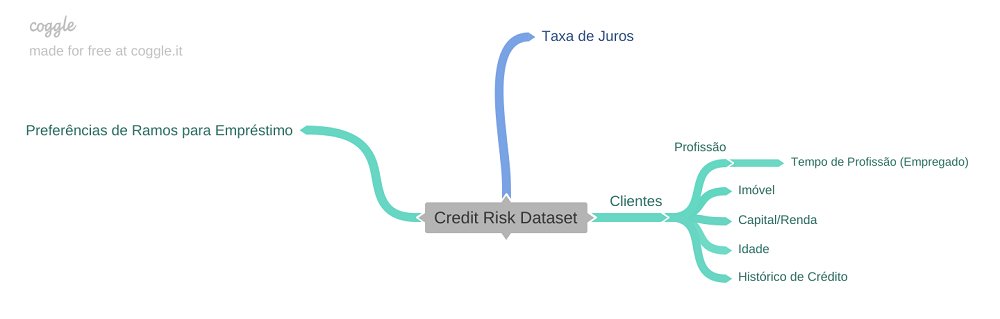

In [30]:
Image ('img/Credit_Risk_Dataset.png')

# 2.2 Criação das Hipóteses

**1.** Clientes com idades menores tendem a fazer mais os empréstimos

**2.** Clientes com mais de sete anos de bom histórico crediário tendem a pagar mais os empréstimos

**3.** Clientes com Imóvel Próprio tendem a pagar mais os empréstimos

**4.** Clientes que tem como finalidade para o empréstimo reformas residênciais são maioria

**5.** Empréstimos mais arriscados tendem a possuir Taxa de Juros mais altas

**6.** Clientes com menos de dez anos empregados tendem a pagar menos os empréstimos

**7.** Clientes com renda superior a 20000 tendem a pagar mais os empréstimos

**8.** Clientes com maior grau de empréstimo tendem a pagar menos os empréstimos

# 3.0 Análise Exploratória de Dados

In [31]:
df3 = df2.copy()

In [32]:
def test_profile():

    proof = pandas_profiling.ProfileReport(df3)
    proof.to_file("credit_out.html")

if __name__ == '__main__':
    multiprocessing.freeze_support()
    test_profile()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 3.1 Análise Univariada

## 3.1.1 Response Variable

<AxesSubplot:title={'center':'Proportion of Status'}>

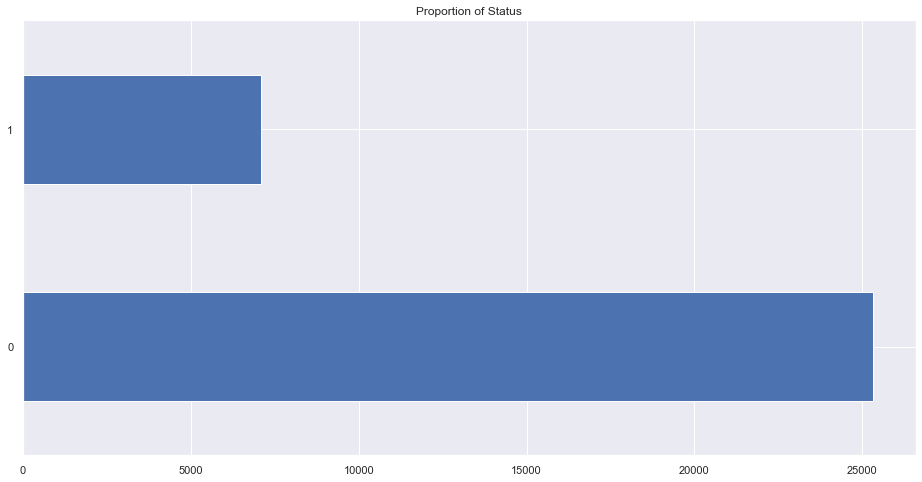

In [33]:
plt.rcParams['figure.figsize'] = [16, 8]
df3['loan_status'].value_counts().plot.barh(title="Proportion of Status")

## 3.1.2 Numerical Variable

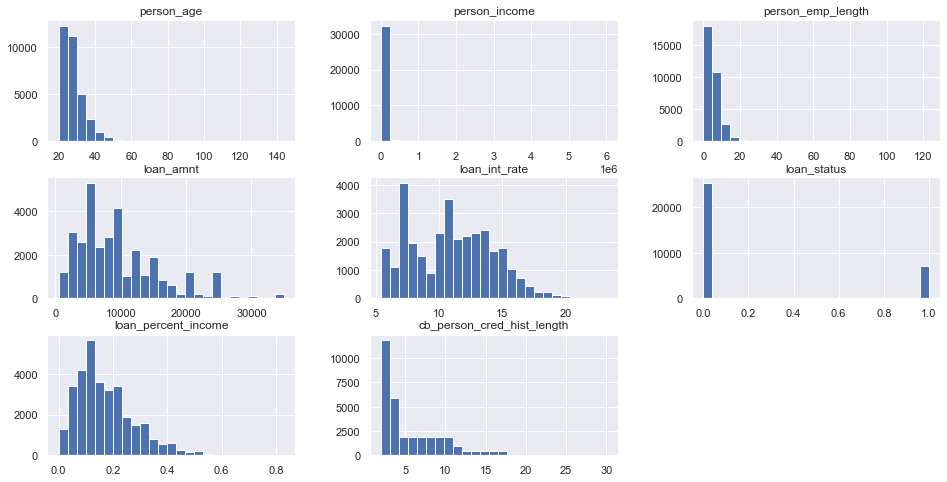

In [34]:
num_attributes.hist(bins = 25);

## 3.1.3 Categorical Variable

In [35]:
cat_attributes.head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y


<AxesSubplot:xlabel='loan_intent', ylabel='count'>

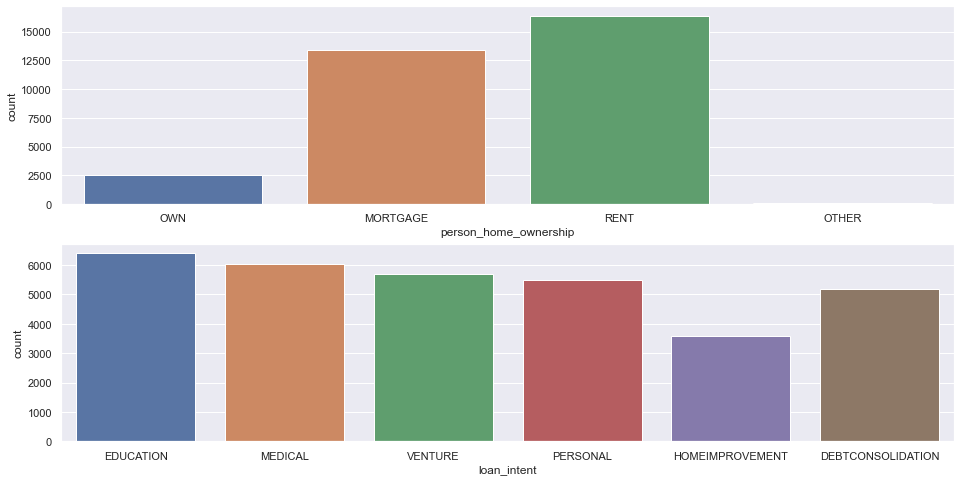

In [36]:
#person_home_ownership
plt.subplot (2,1,1)
sns.countplot(x = 'person_home_ownership', data = df3)

#loan_intent
plt.subplot (2,1,2)
sns.countplot(x = 'loan_intent', data = df3)

<AxesSubplot:xlabel='cb_person_default_on_file', ylabel='count'>

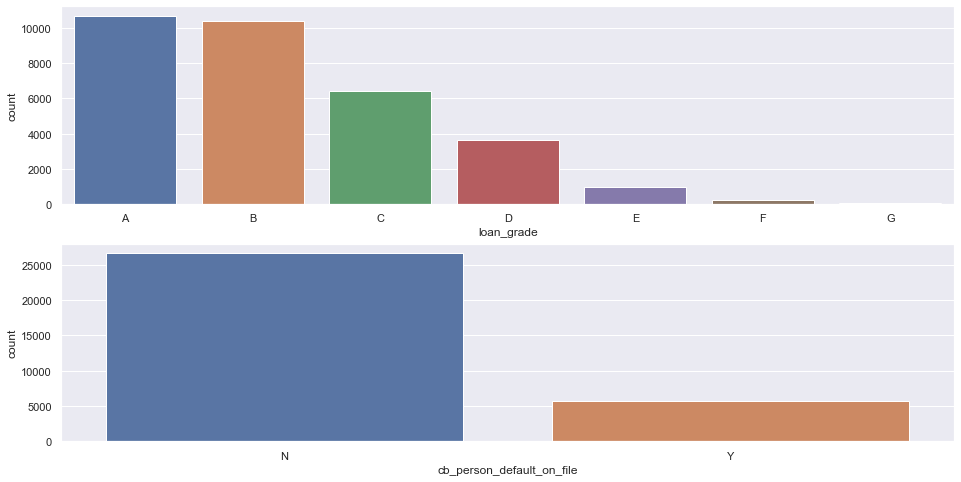

In [37]:
#loan_grade
plt.subplot (2,1,1)
sns.countplot(x = 'loan_grade', data = df3)

#cb_person_default_on_file
plt.subplot (2,1,2)
sns.countplot(x = 'cb_person_default_on_file', data = df3)

# 3.2 Análise Bivariada

**H1.** Clientes com idades menores tendem a fazer mais empréstimos

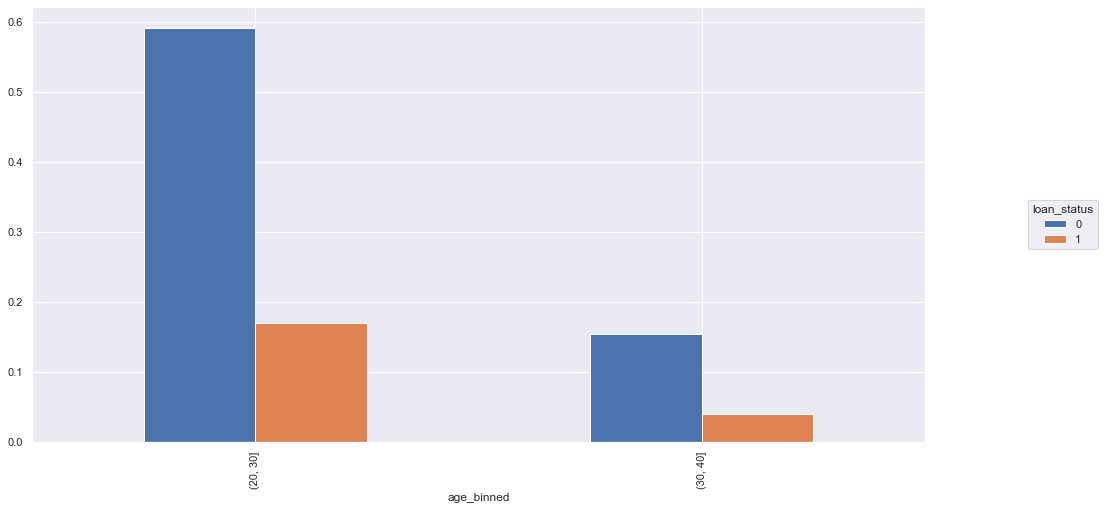

In [38]:
n_obs = df3.shape[0]

bins = list(np.arange( 20, 50, 10))
df3['age_binned'] = pd.cut (df3['person_age'], bins = bins)
counts = (df3[['age_binned','loan_status']]
              .groupby(['age_binned','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
        )

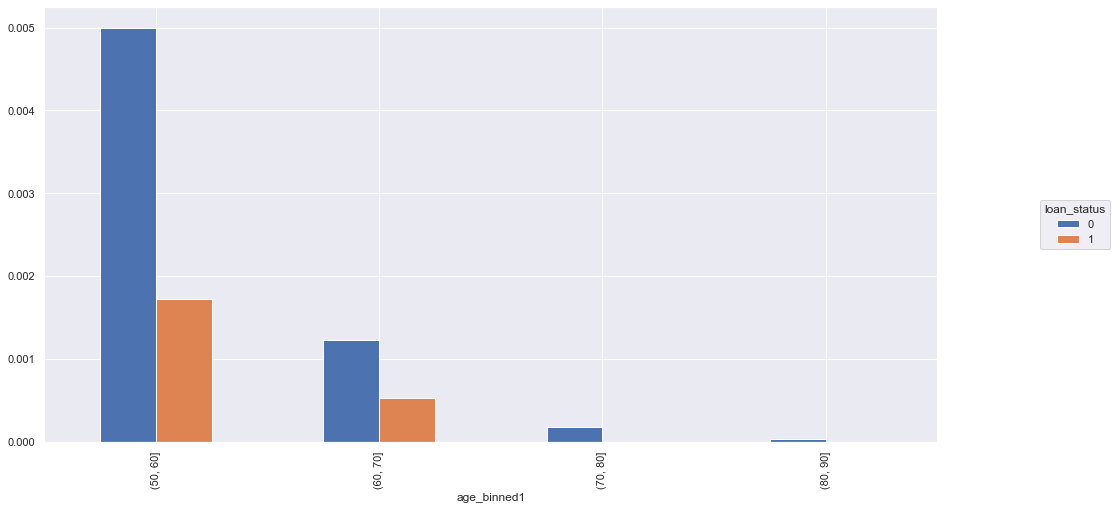

In [39]:
bins1 = list(np.arange( 50, 100, 10))
df3['age_binned1'] = pd.cut (df3['person_age'], bins = bins1)
counts1 = (df3[['age_binned1','loan_status']]
              .groupby(['age_binned1','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
          )

ax = counts1.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
        )

In [40]:
age = pd.concat([counts, counts1], axis=0)
age['0 em %'] = age[0]/(age[0] + age[1])*100
age['1 em %'] = age[1]/(age[0] + age[1])*100
age

loan_status,0,1,0 em %,1 em %
"(20, 30]",0.591256,0.169552,77.714239,22.285761
"(30, 40]",0.153599,0.039279,79.635258,20.364742
"(50, 60]",0.004999,0.001728,74.311927,25.688073
"(60, 70]",0.001234,0.000525,70.175439,29.824561
"(70, 80]",0.000185,0.000000,100.000000,0.000000
"(80, 90]",0.000031,0.000000,100.000000,0.000000


**H2.** Clientes com mais de sete anos de bom histórico crediário tendem a pagar mais os empréstimos

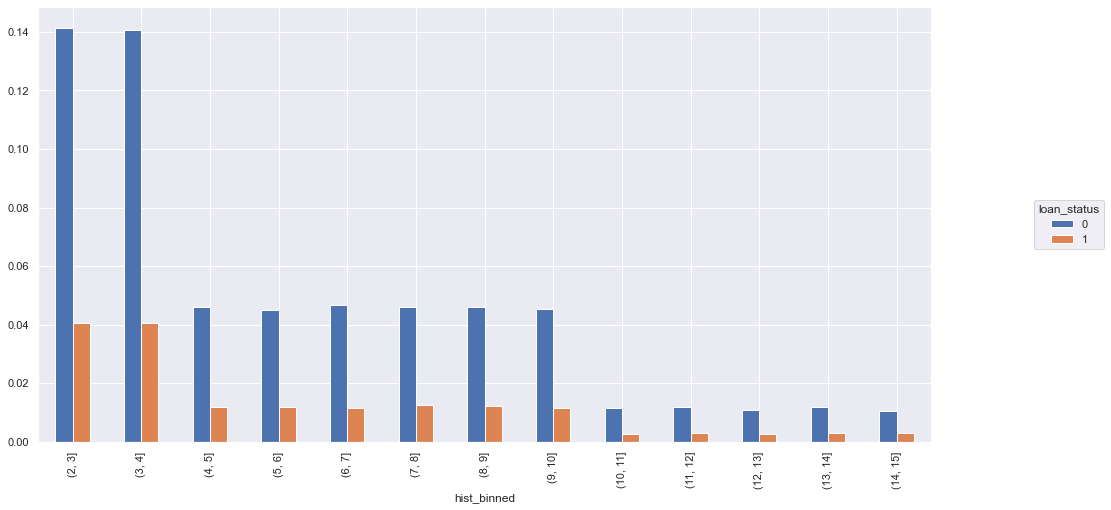

In [41]:
n_obs = df3.shape[0]

bins2 = list(np.arange( 2, 16, 1))
df3['hist_binned'] = pd.cut (df3['cb_person_cred_hist_length'], bins = bins2)
counts2 = (df3[['hist_binned','loan_status']]
              .groupby(['hist_binned','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts2.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
        )

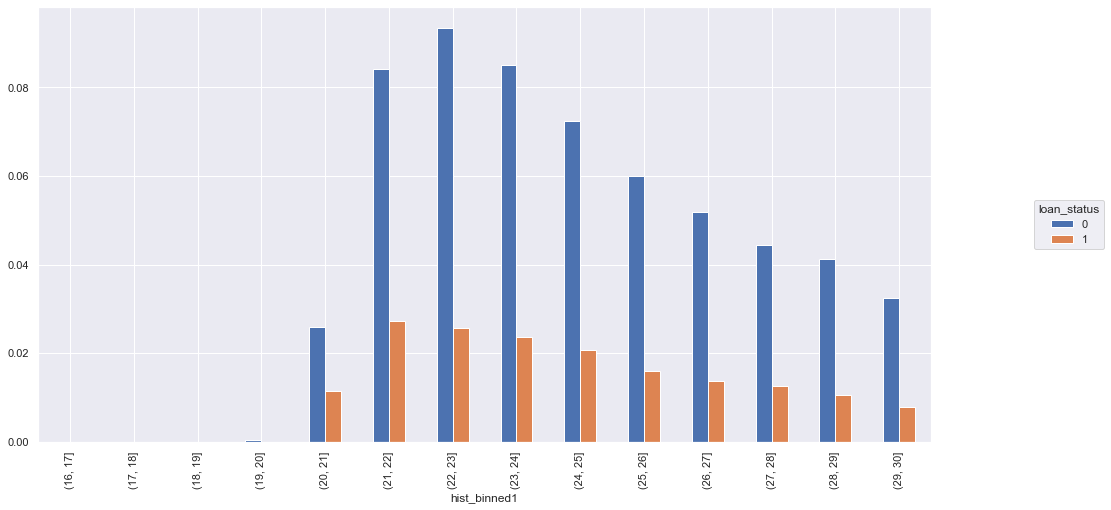

In [42]:
bins3 = list(np.arange( 16, 31, 1))
df3['hist_binned1'] = pd.cut (df3['person_age'], bins = bins3)
counts3 = (df3[['hist_binned1','loan_status']]
              .groupby(['hist_binned1','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
          )

ax = counts3.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
        )

In [43]:
hist_length = pd.concat([counts2, counts3], axis=0)
hist_length['0 em %'] = hist_length[0]/(hist_length[0] + hist_length[1])*100
hist_length['1 em %'] = hist_length[1]/(hist_length[0] + hist_length[1])*100
hist_length

loan_status,0,1,0 em %,1 em %
"(2, 3]",0.141380,0.040729,77.634700,22.365300
"(3, 4]",0.140733,0.040668,77.581221,22.418779
"(4, 5]",0.045975,0.011879,79.466667,20.533333
"(5, 6]",0.045173,0.011879,79.177934,20.822066
"(6, 7]",0.046901,0.011663,80.084299,19.915701
"(7, 8]",0.045913,0.012497,78.605388,21.394612
"(8, 9]",0.046129,0.012126,79.184322,20.815678
"(9, 10]",0.045389,0.011571,79.685807,20.314193
"(10, 11]",0.011417,0.002839,80.086580,19.913420
"(11, 12]",0.011849,0.003055,79.503106,20.496894


**3.** Clientes com Imóvel Próprio tendem a pagar mais os empréstimos

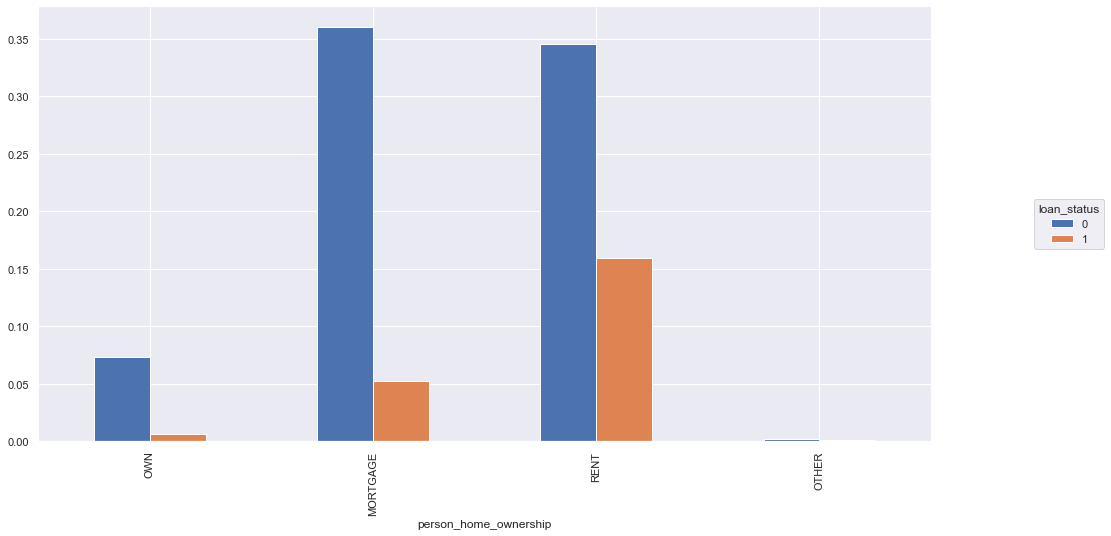

In [44]:
n_obs = df3.shape[0]

counts4 = (df3[['person_home_ownership','loan_status']]
              .groupby(['person_home_ownership','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts4.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status')


In [45]:
counts4['0 em %'] = counts4[0]/(counts4[0] + counts4[1])*100
counts4['1 em %'] = counts4[1]/(counts4[0] + counts4[1])*100
counts4

loan_status,0,1,0 em %,1 em %
person_home_ownership,,,,
OWN,0.073159,0.005924,92.508779,7.491221
MORTGAGE,0.360363,0.052053,87.378423,12.621577
RENT,0.345521,0.159709,68.388909,31.611091
OTHER,0.002252,0.001018,68.867925,31.132075


**4.** Clientes que tem como finalidade para o empréstimo reformas residenciais são maioria

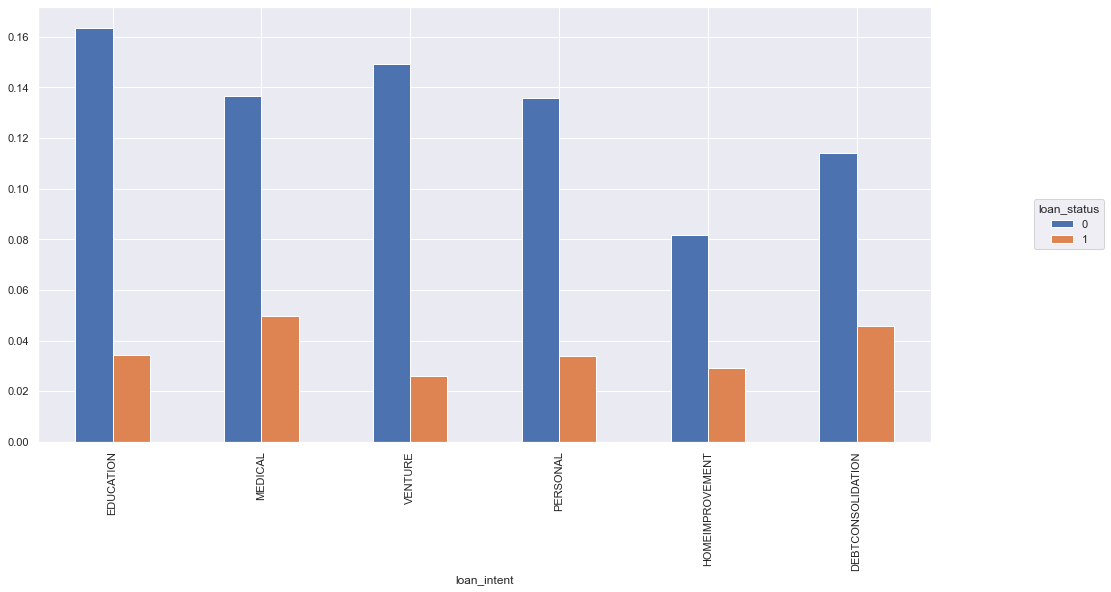

In [46]:
n_obs = df3.shape[0]

counts5 = (df3[['loan_intent','loan_status']]
              .groupby(['loan_intent','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts5.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status')

In [47]:
counts5['0 em %'] = counts5[0]/(counts5[0] + counts5[1])*100
counts5['1 em %'] = counts5[1]/(counts5[0] + counts5[1])*100
counts5['Quantidade Total em %'] = (counts5[0] + counts5[1])*100
counts5

loan_status,0,1,0 em %,1 em %,Quantidade Total em %
loan_intent,,,,,
EDUCATION,0.163627,0.034126,82.743018,17.256982,19.775371
MEDICAL,0.136536,0.049894,73.237339,26.762661,18.642970
VENTURE,0.149187,0.026042,85.138229,14.861771,17.522910
PERSONAL,0.135857,0.033725,80.112809,19.887191,16.958252
HOMEIMPROVEMENT,0.081891,0.029004,73.845298,26.154702,11.089512
DEBTCONSOLIDATION,0.114197,0.045913,71.323955,28.676045,16.010985


**5.** Cliente que obtiveram Empréstimos com taxas Taxa de Juros mais altas tendem a pagar menos os Empréstimos

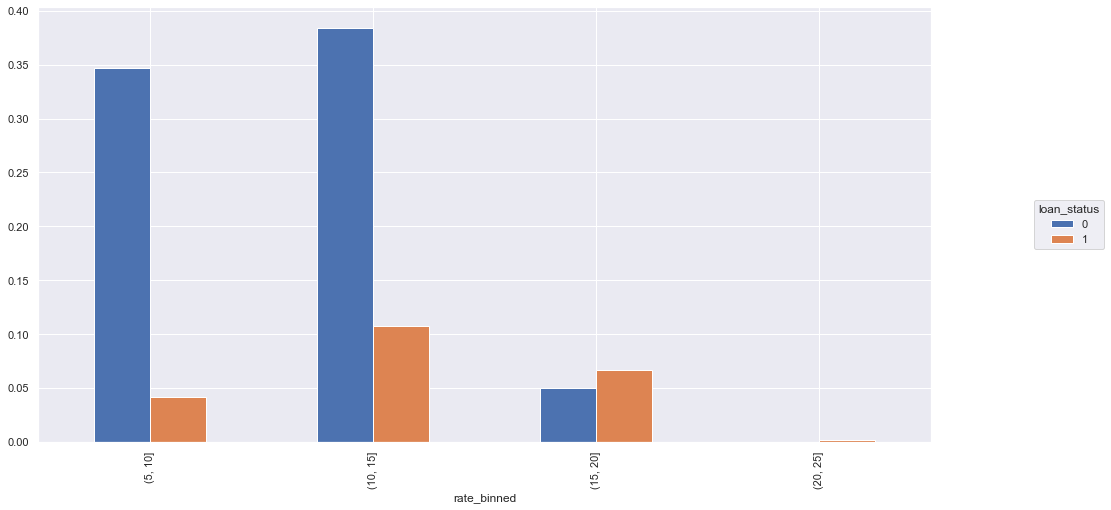

In [48]:
n_obs = df3.shape[0]

bins4 = [5,10,15,20,25]
df3['rate_binned'] = pd.cut (df3['loan_int_rate'], bins = bins4)
counts6 = (df3[['rate_binned','loan_status']]
              .groupby(['rate_binned','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts6.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
        )

In [49]:
counts6['0 em %'] = counts6[0]/(counts6[0] + counts6[1])*100
counts6['1 em %'] = counts6[1]/(counts6[0] + counts6[1])*100
counts6['Quantidade Total em %'] = (counts6[0] + counts6[1])*100
counts6

loan_status,0,1,0 em %,1 em %,Quantidade Total em %
rate_binned,,,,,
"(5, 10]",0.347002,0.042087,89.183188,10.816812,38.908945
"(10, 15]",0.384276,0.107594,78.125588,21.874412,49.186954
"(15, 20]",0.049678,0.066926,42.603863,57.396137,11.660341
"(20, 25]",0.000339,0.002098,13.924051,86.075949,0.243759


**6.** Clientes com menos de dez anos empregados tendem a pagar menos os empréstimos

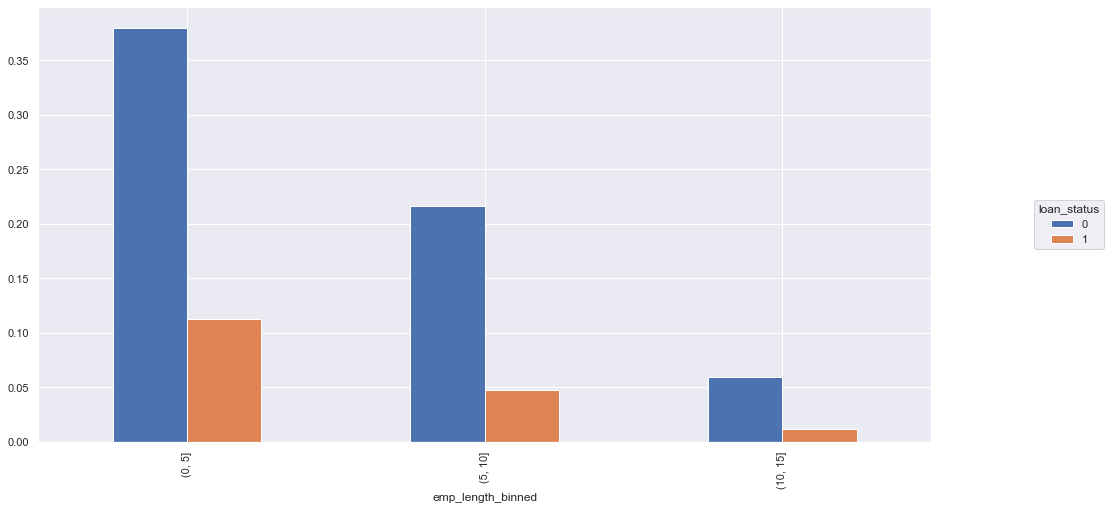

In [50]:
bins5 = list(np.arange( 0, 20, 5))
df3['emp_length_binned'] = pd.cut (df3['person_emp_length'], bins = bins5)
counts7 = (df3[['emp_length_binned','loan_status']]
              .groupby(['emp_length_binned','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
          )

ax = counts7.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
)

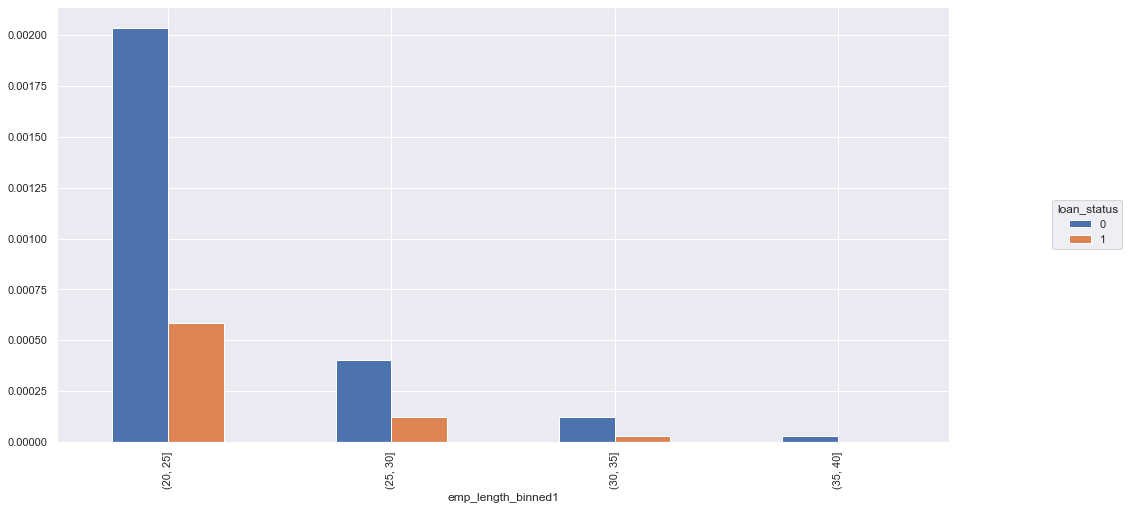

In [51]:
bins6 = list(np.arange( 20, 45, 5))
df3['emp_length_binned1'] = pd.cut (df3['person_emp_length'], bins = bins6)
counts8 = (df3[['emp_length_binned1','loan_status']]
              .groupby(['emp_length_binned1','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
          )

ax = counts8.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
)

In [52]:
emp_length = pd.concat([counts7, counts8], axis=0)

emp_length['0 em %'] = emp_length[0]/(emp_length[0] + emp_length[1])*100
emp_length['1 em %'] = emp_length[1]/(emp_length[0] + emp_length[1])*100
emp_length['Quantidade Total em %'] = (emp_length[0] + emp_length[1])*100
emp_length

loan_status,0,1,0 em %,1 em %,Quantidade Total em %
"(0, 5]",0.380018,0.112345,77.182428,22.817572,49.236323
"(5, 10]",0.216421,0.047826,81.900981,18.099019,26.424759
"(10, 15]",0.059521,0.011540,83.760313,16.239687,7.106051
"(20, 25]",0.002036,0.000586,77.647059,22.352941,0.262273
"(25, 30]",0.000401,0.000123,76.470588,23.529412,0.052455
"(30, 35]",0.000123,0.000031,80.000000,20.000000,0.015428
"(35, 40]",0.000031,0.000000,100.000000,0.000000,0.003086


**7.** Clientes com renda superior a 20000 tendem a pagar mais os empréstimos

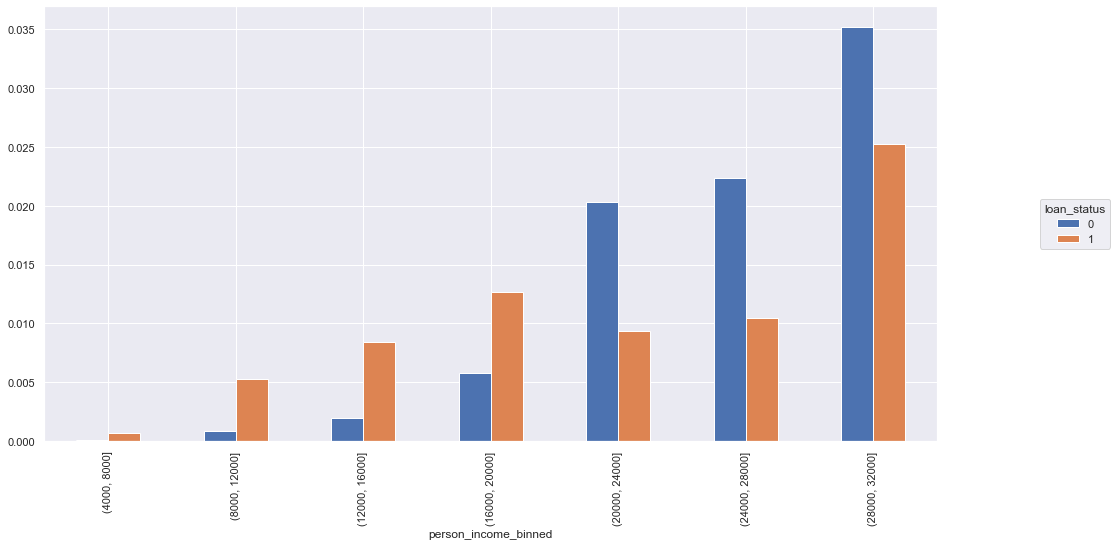

In [53]:
bins7 = list(np.arange( 4000, 34000, 4000))
df3['person_income_binned'] = pd.cut (df3['person_income'], bins = bins7)
counts9 = (df3[['person_income_binned','loan_status']]
              .groupby(['person_income_binned','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
          )

ax = counts9.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status'
)

In [54]:
counts9['0 em %'] = counts9[0]/(counts9[0] + counts9[1])*100
counts9['1 em %'] = counts9[1]/(counts9[0] + counts9[1])*100
counts9

loan_status,0,1,0 em %,1 em %
person_income_binned,,,,
"(4000, 8000]",0.000123,0.000710,14.814815,85.185185
"(8000, 12000]",0.000864,0.005276,14.070352,85.929648
"(12000, 16000]",0.001944,0.008424,18.750000,81.250000
"(16000, 20000]",0.005832,0.012651,31.552588,68.447412
"(20000, 24000]",0.020272,0.009380,68.366285,31.633715
"(24000, 28000]",0.022370,0.010491,68.075117,31.924883
"(28000, 32000]",0.035175,0.025271,58.192956,41.807044


**8.** Clientes com maior grau de empréstimo tendem a pagar menos os empréstimos

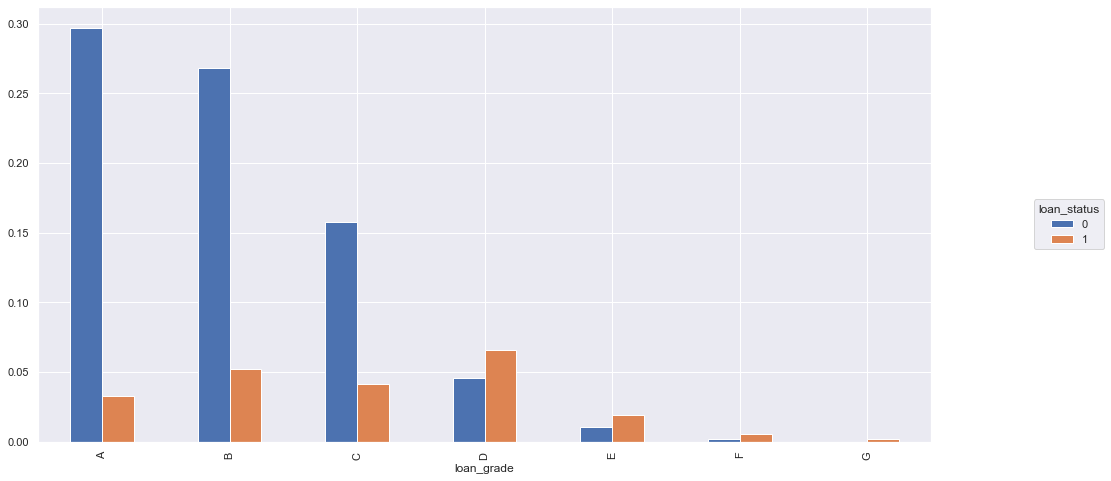

In [55]:
n_obs = df3.shape[0]

counts10 = (df3[['loan_grade','loan_status']]
              .groupby(['loan_grade','loan_status'])
              .size()
              .div(n_obs)
              .unstack('loan_status')
         )

ax = counts10.plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.2, 0.5), 
    title='loan_status')

In [56]:
counts10['0 em %'] = counts10[0]/(counts10[0] + counts10[1])*100
counts10['1 em %'] = counts10[1]/(counts10[0] + counts10[1])*100
counts10['Quantidade Total em %'] = (counts10[0] + counts10[1])*100
counts10

loan_status,0,1,0 em %,1 em %,Quantidade Total em %
loan_grade,,,,,
A,0.297325,0.032892,90.039245,9.960755,33.021692
B,0.268105,0.052300,83.676810,16.323190,32.040483
C,0.157364,0.041223,79.241765,20.758235,19.858681
D,0.045728,0.065938,40.950539,59.049461,11.166651
E,0.010553,0.019161,35.514019,64.485981,2.971397
F,0.002191,0.005245,29.460581,70.539419,0.743621
G,0.000031,0.001944,1.562500,98.437500,0.197476


In [57]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
['H1', 'Verdadeira', 'Alta'],
['H2', 'Há Excessões', 'Media'],
['H3', 'Verdadeira', 'Media'],
['H4', 'Falsa', 'Media'],
['H5', 'Verdadeira', 'Alta'],
['H6', 'Há Excessões', 'Media'],
['H7', 'Verdadeira', 'Alta'],
['H8', 'Verdadeira', 'Alta']
]
print( tabulate( tab ) )

---------  ------------  ----------
Hipóteses  Conclusão     Relevância
H1         Verdadeira    Alta
H2         Há Excessões  Media
H3         Verdadeira    Media
H4         Falsa         Media
H5         Verdadeira    Alta
H6         Há Excessões  Media
H7         Verdadeira    Alta
H8         Verdadeira    Alta
---------  ------------  ----------


# 3.3 Análise Multivarida

#### 3.3.1 Numerical Variable

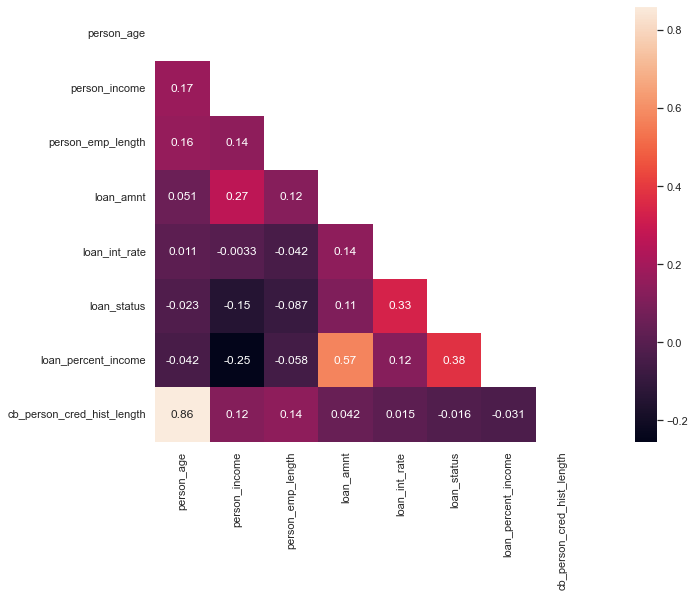

In [58]:
corr = num_attributes.corr( method = 'pearson')

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    ax = sns.heatmap(corr, mask=mask, square=True, annot = True)

#### 3.3.2 Categorical Variable

In [59]:
df3.head()

,df_index,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_binned,age_binned1,hist_binned,hist_binned1,rate_binned,emp_length_binned,emp_length_binned1,person_income_binned
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,"(20, 30]",NaN,NaN,"(20, 21]","(10, 15]","(0, 5]",NaN,"(8000.0, 12000.0]"
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,"(20, 30]",NaN,"(2.0, 3.0]","(24, 25]","(10, 15]","(0, 5]",NaN,"(8000.0, 12000.0]"
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,"(20, 30]",NaN,NaN,"(22, 23]","(15, 20]","(0, 5]",NaN,NaN
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,"(20, 30]",NaN,"(3.0, 4.0]","(23, 24]","(10, 15]","(5, 10]",NaN,NaN
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,"(20, 30]",NaN,NaN,"(20, 21]","(5, 10]","(0, 5]",NaN,"(8000.0, 12000.0]"


In [60]:
#list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range (len (cat_attributes_list)):
    corr_list = []
    for j in range (len (cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #correlation
        corr = cramer_v(df3[ref], df3[feat])
        
        #append a list
        corr_list.append (corr)
    
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_list


<AxesSubplot:>

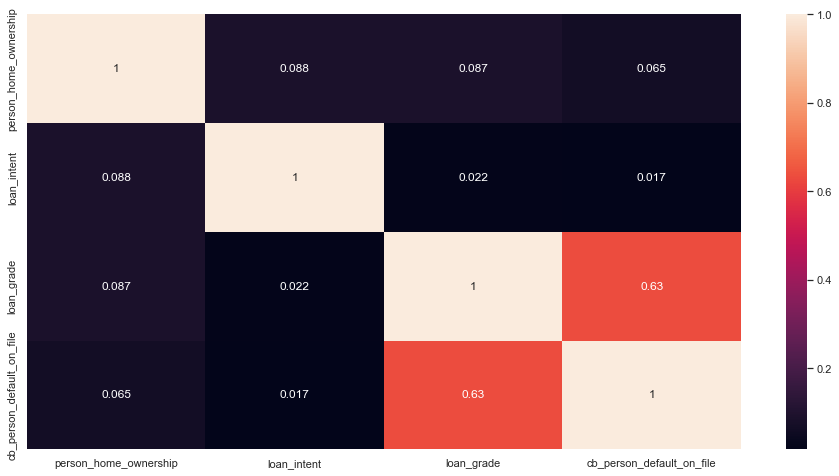

In [61]:
d = pd.DataFrame (corr_dict)
d = d.set_index (d.columns)

sns.heatmap (d, annot = True)

## 4.0. Data Preparation

In [62]:
df4 = df3.copy()

In [63]:
df3.head()

,df_index,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_binned,age_binned1,hist_binned,hist_binned1,rate_binned,emp_length_binned,emp_length_binned1,person_income_binned
0,1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,"(20, 30]",NaN,NaN,"(20, 21]","(10, 15]","(0, 5]",NaN,"(8000.0, 12000.0]"
1,2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,"(20, 30]",NaN,"(2.0, 3.0]","(24, 25]","(10, 15]","(0, 5]",NaN,"(8000.0, 12000.0]"
2,3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,"(20, 30]",NaN,NaN,"(22, 23]","(15, 20]","(0, 5]",NaN,NaN
3,4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,"(20, 30]",NaN,"(3.0, 4.0]","(23, 24]","(10, 15]","(5, 10]",NaN,NaN
4,5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,"(20, 30]",NaN,NaN,"(20, 21]","(5, 10]","(0, 5]",NaN,"(8000.0, 12000.0]"


### 4.1. Rescaling

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

#person_age
df4['person_age']  = rs.fit_transform ( df4[['person_age']].values)
pickle.dump( rs, open( '/Users/marin/reposit/Credit_Card_Risk/deploy/person_age_scaler.pkl', 'wb' ))

#person_income
df4['person_income']  = rs.fit_transform ( df4[['person_income']].values)
pickle.dump( rs, open( '/Users/marin/reposit/Credit_Card_Risk/deploy/person_income_scaler.pkl', 'wb' ))

#person_emp_length
df4['person_emp_length']  = rs.fit_transform ( df4[['person_emp_length']].values)

#loan_amnt
df4['loan_amnt']  = rs.fit_transform ( df4[['loan_amnt']].values)
pickle.dump( rs, open( '/Users/marin/reposit/Credit_Card_Risk/deploy/loan_amnt_scaler.pkl', 'wb' ))

#loan_int_rate
df4['loan_int_rate']  = mms.fit_transform ( df4[['loan_int_rate']].values)

#loan_percent_income
df4['loan_percent_income']  = rs.fit_transform ( df4[['loan_percent_income']].values)

#cb_person_cred_hist_length
df4['cb_person_cred_hist_length']  = rs.fit_transform ( df4[['cb_person_cred_hist_length']].values)

### 4.2. Tranformacao

In [65]:
#person_home_ownership
lab_enc_home = LabelEncoder()
df4['person_home_ownership'] = lab_enc_home.fit_transform(df4['person_home_ownership'])
pickle.dump( lab_enc_home, open( '/Users/marin/reposit/Credit_Card_Risk/deploy/person_home_ownership_scaler.pkl', 'wb' ))

#loan_intent
lab_enc_intent = LabelEncoder()
df4['loan_intent'] = lab_enc_home.fit_transform(df4['loan_intent'])

#cb_person_default_on_file
lab_enc_file = LabelEncoder()
df4['cb_person_default_on_file'] = lab_enc_home.fit_transform(df4['cb_person_default_on_file'])

#loan_grade
enc_grade_dict = {'A':1 ,'B':2 ,'C':3 ,'D':4 ,'E':5 ,'F':6 , 'G':7}
df4['loan_grade'] = df4['loan_grade'].map( enc_grade_dict )

### 5.0. Feature Selection

In [66]:
df5 = df4.copy()

In [67]:
df5.columns

Index(['df_index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_binned',
       'age_binned1', 'hist_binned', 'hist_binned1', 'rate_binned',
       'emp_length_binned', 'emp_length_binned1', 'person_income_binned'],
      dtype='object')

In [68]:
cols_drop = ['df_index','age_binned','age_binned1', 'hist_binned', 'hist_binned1', 'rate_binned','emp_length_binned', 'emp_length_binned1', 'person_income_binned']
df5 = df5.drop( cols_drop, axis=1 )

### 6.0. Machine Learning Modelling

In [69]:
df6 = df5.copy()

In [70]:
df6.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-0.714286,-1.115479,2,0.2,1,2,-0.965517,0.321348,0,-0.357143,0,-0.4
1,-0.142857,-1.115479,0,-0.6,3,3,-0.344828,0.418539,1,3.000000,0,-0.2
2,-0.428571,0.257985,3,0.0,3,3,3.724138,0.551124,1,2.714286,0,-0.4
3,-0.285714,-0.014742,3,0.8,3,3,3.724138,0.497191,1,2.857143,1,0.0
4,-0.714286,-1.108108,2,-0.4,5,1,-0.758621,0.096629,1,0.714286,0,-0.4


In [71]:
df6.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [72]:
X_credit = df6.drop('loan_status',1).values

C:\Users\marin\AppData\Local\Temp/ipykernel_6924/1939672686.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_credit = df6.drop('loan_status',1).values


In [73]:
y_credit = df6.loc[:,'loan_status'].values

In [74]:
X_cred_train, X_cred_test, y_cred_train, y_cred_teste = train_test_split(X_credit, y_credit, test_size = 0.25, random_state = 123 ,shuffle = True ,stratify = y_credit,)

In [75]:
arvore_credit = DecisionTreeClassifier(criterion='entropy', random_state = 0)
arvore_credit.fit(X_cred_train, y_cred_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [76]:
prev = arvore_credit.predict(X_cred_test)

In [77]:
accuracy_score(y_cred_teste, prev)

0.888066148340121

In [78]:
confusion_matrix(y_cred_teste, prev)

array([[5858,  473],
       [ 434, 1338]], dtype=int64)

In [79]:
print(classification_report(y_cred_teste, prev))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6331
           1       0.74      0.76      0.75      1772

    accuracy                           0.89      8103
   macro avg       0.83      0.84      0.84      8103
weighted avg       0.89      0.89      0.89      8103



In [80]:
pickle.dump( arvore_credit, open ('/Users/marin/reposit/Credit_Card_Risk/algrts_ml/model_credit_risk.pkl', 'wb'))

### 7.0. Deploy - Prediction

In [81]:
df = df6.drop('loan_status', axis = 1)

In [82]:
data = df.to_json(orient = 'records')
#data = json.dumps(df.to_dict ( orient = 'records'))

In [83]:
#url = 'http://192.168.0.108:5000/predict'

url = 'https://credit-risk-model-app.herokuapp.com/predict'

data = data

header = {'Content-type': 'application/json'}

#Request

r = requests.post( url = url, data = data, headers = header)
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Foi forçado o cancelamento de uma conexão existente pelo host remoto', None, 10054, None))

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.columns

In [ ]:
d1['prediction'].value_counts().plot.barh(title="Proportion of Status")

### 8.0. Class In Production

In [ ]:
class CreditRisk( object ):
    def __init__( self ):
        self.person_age_scaler = pickle.load( open( 'parameter/person_age_scaler.pkl', 'rb'))
        self.loan_amnt_scaler = pickle.load( open( 'parameter/loan_amnt_scaler.pkl', 'rb'))
        self.person_income_scaler = pickle.load( open( 'parameter/person_income_scaler.pkl', 'rb'))
        self.person_home_ownership_scaler = pickle.load( open( 'parameter/person_home_ownership_scaler.pkl', 'rb'))
        
        
    
    def data_preparation( self, df ):
        
        df['person_age_scaler'] = self.person_age_scaler.transform( df[['person_age_scaler']].values  )
        df['loan_amnt_scaler'] = self.loan_amnt_scaler.transform( df[['loan_amnt_scaler']].values  )
        df['person_income_scaler'] = self.person_income_scaler.transform( df[['person_income_scaler']].values )
        df['person_home_ownership_scaler'] = self.person_home_ownership_scaler.transform( df[['person_home_ownership_scaler']].values  )
        
        return df